## Weaviate 1.31 Enablement session

### Key features

- Shard movement between nodes
- MUVERA encoding algorithm for multi-vector embeddings
- Vectorizer changes
- HNSW snapshotting

### Connect to Weaviate

In [1]:
import dotenv

dotenv.load_dotenv(verbose=True)

True

In [2]:
import weaviate
import os

client = weaviate.connect_to_local(
    headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),
        "X-JinaAI-Api-Key": os.getenv("JINAAI_API_KEY")
    }
)

In [3]:
client.get_meta()["version"]

'1.31.0-rc.0'

Check the cluster setup:

In [4]:
client.cluster.nodes()

[Node(git_hash='a6ede0c', name='node1', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0'),
 Node(git_hash='a6ede0c', name='node2', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0'),
 Node(git_hash='a6ede0c', name='node3', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0')]

Pre-load some data:

In [5]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
    ],
    replication_config=Configure.replication(factor=2),  # Note - this just a demo - do NOT use a RF of 2 in production - use 3 or above odd number
    sharding_config=Configure.sharding(
        desired_count=5  # To demonstrate sharding, we set it to an arbitrary high number (for our dataset size, anyway)
    )
)

c = client.collections.get(collection_name)

objects = [
    {"title": "Howl's Moving Castle", "body": "A fantasy novel by Diana Wynne Jones."},
    {"title": "The Hobbit", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "The Hitchhiker's Guide to the Galaxy", "body": "A science fiction novel by Douglas Adams."},
    {"title": "The Great Gatsby", "body": "A novel by F. Scott Fitzgerald."},
    {"title": "1984", "body": "A dystopian novel by George Orwell."},
    {"title": "To Kill a Mockingbird", "body": "A novel by Harper Lee."},
    {"title": "Pride and Prejudice", "body": "A novel by Jane Austen."},
    {"title": "The Catcher in the Rye", "body": "A novel by J.D. Salinger."},
    {"title": "The Lord of the Rings", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "Brave New World", "body": "A dystopian novel by Aldous Huxley."},
    {"title": "Fahrenheit 451", "body": "A dystopian novel by Ray Bradbury."},
    {"title": "The Picture of Dorian Gray", "body": "A novel by Oscar Wilde."},
]

c.data.insert_many(objects)

import time

start_time = time.time()
print("Waiting for object count to update...")

while True:
    n = client.cluster.nodes(collection=collection_name, output="verbose")[0]
    s = n.shards[0]
    if s.object_count != 0:
        print(f"On node {n.name} and shard {s.name} - obj count: {s.object_count}")
        break
    time.sleep(10)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.1f}s")

finish_time = time.time()
print(f"Time taken for obj count to update: {finish_time - start_time} seconds")

/workspaces/weaviate_enablement_1_31/.venv/lib/python3.11/site-packages/weaviate/collections/classes/config.py:1950: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


Waiting for object count to update...


KeyboardInterrupt: 

In [ ]:
len(c)

## Move shards

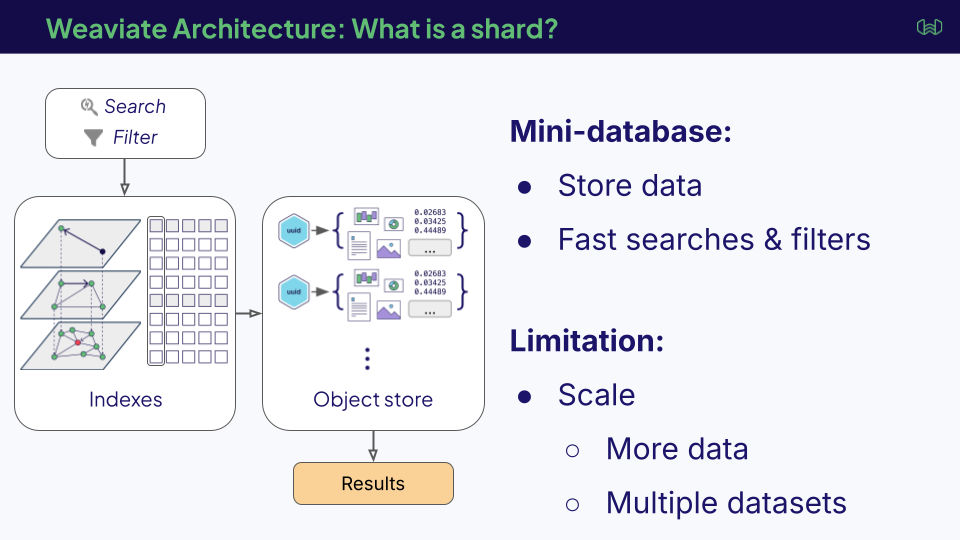

In [25]:
from IPython.display import Image, display

img_w = 600
display(Image('./assets/shards-1.png', width=img_w))

In [ ]:
display(Image('./assets/shards-2.png', width=img_w))

In [ ]:
display(Image('./assets/shards-3.png', width=img_w))

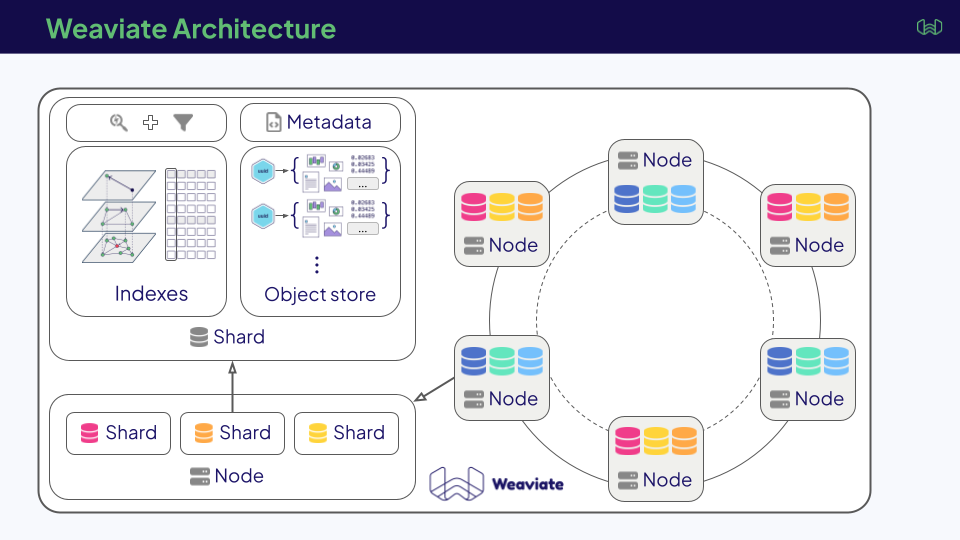

In [26]:
display(Image('./assets/shards-4.png', width=img_w))

In [ ]:
nodes_response = client.cluster.nodes(collection=collection_name, output="verbose")

for n in nodes_response:
    print(f"\nNode {n.name} has {len(n.shards)} shards")
    for s in n.shards:
        print(f"Shard {s.name} has {s.object_count} objects from {collection_name}")

In [ ]:
n = nodes_response[0]
candidate_shard = None
for src_shard in n.shards:
    node2_shards = [
        n2_shard.name for n2_shard in nodes_response[1].shards
    ]
    if src_shard.name not in node2_shards:
        candidate_shard = src_shard
        break

print(f"Candidate shard to move: {candidate_shard.name}")

SHARD_ID = candidate_shard.name

In [ ]:
import requests
import json

# Shard move parameters
SOURCE_NODE = "node1"
DESTINATION_NODE = "node2"

# Create the request payload
payload = {
    "sourceNodeName": "node1",
    "destinationNodeName": DESTINATION_NODE,
    "collectionId": collection_name,
    "shardId": SHARD_ID,
    "transferType": "MOVE"  # Use "MOVE" to relocate the shard, or "COPY" to replicate it
}

# Set up the headers
headers = {
    "Content-Type": "application/json"
}

# Make the API request
response = requests.post(
    f"http://localhost:8080/v1/replication/replicate",
    headers=headers,
    data=json.dumps(payload)
)

operation_id = response.json().get("id")

# Check for the status of the operation
response = requests.get(
    f"http://localhost:8080/v1/replication/replicate/{operation_id}",
    headers=headers,
)

print(response.json())
print("Shard move operation status:")
print(f'Status: {response.json()["status"]["state"]}')

In [ ]:
display(Image('./assets/shards-5.png', width=img_w))

Check the status to see if it's finished:

In [ ]:
# Check for the status of the operation
response = requests.get(
    f"http://localhost:8080/v1/replication/replicate/{operation_id}",
    headers=headers,
)

print(response.json())
print("Shard move operation status:")
print(f'Status: {response.json()["status"]["state"]}')

In [ ]:
for n in client.cluster.nodes(collection=collection_name, output="verbose"):
    print(f"\nNode {n.name} has {len(n.shards)} shards")
    for s in n.shards:
        print(f"Shard {s.name} has {s.object_count} objects from {collection_name}")

## MUVERA

Note - check that this is the branch being used:

`uv pip install git+https://github.com/weaviate/weaviate-python-client.git@dev/1.31`

In [ ]:
from IPython.display import Image, display

img_w = 800
display(Image('./assets/mv_explained1.png', width=img_w))

In [ ]:
from IPython.display import Image, display

img_w = 800
display(Image('./assets/mv_explained2.png', width=img_w))

In [ ]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2colbert_jinaai(
            name="custom_mv",
            source_properties=["title", "body"],
            vector_index_config=Configure.VectorIndex.hnsw(
                multi_vector=Configure.VectorIndex.MultiVector.multi_vector(
                    encoding=Configure.VectorIndex.MultiVector.Encoding.muvera()
                )
            )
        ),
    ],
    replication_config=Configure.replication(factor=3)
)

In [ ]:
c = client.collections.get(collection_name)

with c.batch.fixed_size(200) as batch:
    for i, obj in enumerate(objects):
        batch.add_object(
            properties=obj,
        )

In [ ]:
r = c.query.near_text(
    query="a bunch of friends travelling around unseen places"
)

for o in r.objects:
    print(o.properties)

## Vectorizer changes

Note - check that this is the branch being used:

`uv pip install git+https://github.com/weaviate/weaviate-python-client.git@1.31/support-adding-vectors`

In [6]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
        Configure.NamedVectors.text2vec_cohere(
            name="new_title",
            source_properties=["title"],
        )
    ],
)

In [8]:
c = client.collections.get(collection_name)

print(c.config.get().vector_config.keys())

dict_keys(['default', 'new_title'])


In [9]:
c.config.add_vector(
    vector_config=Configure.NamedVectors.text2vec_cohere(
        name="body_only",
        source_properties=["body"],
    )
)

In [10]:
c = client.collections.get(collection_name)

print(c.config.get().vector_config.keys())

dict_keys(['body_only', 'default', 'new_title'])


In [11]:
len(c)

0

In [12]:
c.data.insert_many(objects)

BatchObjectReturn(_all_responses=[UUID('9698c6ec-17bb-43f4-8acb-4a3e4d3b5492'), UUID('b45e1ae3-ba9a-4261-a1d9-000171bf9460'), UUID('695cc0b6-4e9d-4ecb-a1a2-b2c0282385db'), UUID('a547ad23-54d0-44f3-bdc5-7de4d055a832'), UUID('2d8f7dcf-f26e-460b-9be0-f455cdb9a0f4'), UUID('76685ba0-bf49-49d5-b8d8-50a8b0896713'), UUID('ba3efb79-d41c-4ab7-8490-a62fa61bd529'), UUID('7a06fd04-02c0-4d4c-bdf3-afa86f58efd6'), UUID('81253708-5d2d-42d7-bdbb-b3b585094b1a'), UUID('2719079a-5cfc-4845-af2b-a283a9df340b'), UUID('395d75cd-1f4e-4e9f-ad24-771ce1a7c24e'), UUID('2164e85e-9e7d-4b4b-a896-322e6e3017c5')], elapsed_seconds=0.42962050437927246, errors={}, uuids={0: UUID('9698c6ec-17bb-43f4-8acb-4a3e4d3b5492'), 1: UUID('b45e1ae3-ba9a-4261-a1d9-000171bf9460'), 2: UUID('695cc0b6-4e9d-4ecb-a1a2-b2c0282385db'), 3: UUID('a547ad23-54d0-44f3-bdc5-7de4d055a832'), 4: UUID('2d8f7dcf-f26e-460b-9be0-f455cdb9a0f4'), 5: UUID('76685ba0-bf49-49d5-b8d8-50a8b0896713'), 6: UUID('ba3efb79-d41c-4ab7-8490-a62fa61bd529'), 7: UUID('7a06fd

In [13]:
r = c.query.fetch_objects(limit=3, include_vector=True)

In [14]:
for o in r.objects:
    print(o.properties)
    for k, v in o.vector.items():
        print(k)
        print(v[:5])

{'title': 'The Picture of Dorian Gray', 'body': 'A novel by Oscar Wilde.'}
body_only
[-0.01383209228515625, 0.00923919677734375, -0.01116180419921875, 0.05743408203125, -0.0504150390625]
default
[0.0051116943359375, 0.021270751953125, -0.01433563232421875, 0.09051513671875, -0.044464111328125]
new_title
[0.0140380859375, 0.0301666259765625, -0.00789642333984375, 0.059326171875, -0.019500732421875]
{'title': 'Brave New World', 'body': 'A dystopian novel by Aldous Huxley.'}
body_only
[-0.01474761962890625, 0.035064697265625, 0.0005087852478027344, 0.043426513671875, -0.061309814453125]
default
[-0.00498199462890625, 0.04095458984375, 0.041259765625, 0.0567626953125, -0.052276611328125]
new_title
[0.00893402099609375, 0.023895263671875, 0.04180908203125, 0.03662109375, -0.03302001953125]
{'title': '1984', 'body': 'A dystopian novel by George Orwell.'}
body_only
[-0.00461578369140625, 0.03570556640625, -0.00139617919921875, 0.044647216796875, -0.04742431640625]
default
[-0.0025711059570312

### The order matters

In [20]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="title",
            source_properties=["title"],
        ),
    ],
)

In [21]:
c = client.collections.get(collection_name)

c.data.insert_many(objects)

BatchObjectReturn(_all_responses=[UUID('48d4802d-b22c-4f97-a62f-536084f4dab2'), UUID('2948c3fd-606f-451a-a4c7-930805035b1b'), UUID('22cb9cd0-7a63-4230-b111-c146218cf9ce'), UUID('5585f501-a4c2-4aee-8d80-89df2d1c2d6e'), UUID('4a267ff3-dff3-4857-8f45-8fba1964d071'), UUID('d6fdc3b2-da1d-43ab-a6d5-46ee679402a9'), UUID('cf82654b-e300-4ce8-be3a-e3b4980b2ee1'), UUID('cd87acab-49c7-4f82-b73b-a2ffb4d9ce0e'), UUID('ecb63a5a-7443-4134-9318-4a84bae59bab'), UUID('ab7b5366-51e4-40b4-9b91-6347d3a263e3'), UUID('b3809619-72e2-41db-85ab-8d91af41cbe2'), UUID('b804ba33-34d4-49eb-9871-cc6deda5a77d')], elapsed_seconds=0.5600042343139648, errors={}, uuids={0: UUID('48d4802d-b22c-4f97-a62f-536084f4dab2'), 1: UUID('2948c3fd-606f-451a-a4c7-930805035b1b'), 2: UUID('22cb9cd0-7a63-4230-b111-c146218cf9ce'), 3: UUID('5585f501-a4c2-4aee-8d80-89df2d1c2d6e'), 4: UUID('4a267ff3-dff3-4857-8f45-8fba1964d071'), 5: UUID('d6fdc3b2-da1d-43ab-a6d5-46ee679402a9'), 6: UUID('cf82654b-e300-4ce8-be3a-e3b4980b2ee1'), 7: UUID('cd87aca

In [22]:
r = c.query.fetch_objects(limit=3, include_vector=True)

for o in r.objects:
    print("\n", o.properties)
    for k, v in o.vector.items():
        print(k)
        print(v[:5])


 {'title': "The Hitchhiker's Guide to the Galaxy", 'body': 'A science fiction novel by Douglas Adams.'}
title
[-0.002246856689453125, 0.042388916015625, -0.007415771484375, 0.040069580078125, -0.05316162109375]

 {'title': 'The Hobbit', 'body': 'A fantasy novel by J.R.R. Tolkien.'}
title
[0.01276397705078125, 0.0540771484375, 0.0274200439453125, 0.0233001708984375, -0.01375579833984375]

 {'title': "Howl's Moving Castle", 'body': 'A fantasy novel by Diana Wynne Jones.'}
title
[0.00046539306640625, 0.0167388916015625, 0.0046539306640625, 0.04193115234375, -0.0230865478515625]


In [23]:
c.config.add_vector(
    vector_config=Configure.NamedVectors.text2vec_cohere(
        name="body_only",
        source_properties=["body"],
    )
)

In [19]:
r = c.query.fetch_objects(limit=3, include_vector=True)

for o in r.objects:
    print(o.properties)
    for k, v in o.vector.items():
        print(k)
        print(v[:5])

{'title': 'The Great Gatsby', 'body': 'A novel by F. Scott Fitzgerald.'}
new_title
[0.002689361572265625, 0.0279083251953125, -0.005222320556640625, 0.03863525390625, -0.01020050048828125]
default
[-0.00426483154296875, 0.032379150390625, -0.0165252685546875, 0.062255859375, -0.037322998046875]
{'title': 'The Lord of the Rings', 'body': 'A fantasy novel by J.R.R. Tolkien.'}
new_title
[0.006343841552734375, 0.0576171875, -0.0017576217651367188, 0.01885986328125, -0.0126495361328125]
default
[-0.0235137939453125, 0.043548583984375, 0.011260986328125, 0.029296875, -0.033843994140625]
{'title': "Howl's Moving Castle", 'body': 'A fantasy novel by Diana Wynne Jones.'}
new_title
[0.00046539306640625, 0.0167388916015625, 0.0046539306640625, 0.04193115234375, -0.0230865478515625]
default
[-0.02838134765625, 0.0147247314453125, -0.0009617805480957031, 0.0273284912109375, -0.01192474365234375]


In [ ]:
r = c.query.fetch_objects(limit=1, include_vector=True)

for k, v in r.objects[0].vector.items():
    print(k)
    print(v[:3])